In [1]:
# ANN OCR trained with Noise
# numpy/tensorflow/keras
#
# ICIN/IC Ex1 - Ago/2018 - Adolfo Bauchspiess
#
# Modificado por Luan Haickel Araújo 1/2019

import numpy as np

from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.lines as lines

import tensorflow as tf
 
import geraChar


N=   6# Levels of noise
Nnt= 10# Number of training noise samples for each noise level
Nnv= 500# Number of validating noise samples
NStep=  10# Noise step

P=[]  # Pattern
T=[]  # Target
Pn=[] # Noise Pattern
fitT=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training
fitV=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training


Using TensorFlow backend.


In [2]:
# create models with 0, 10, 20 .... 90% noisy bit
# não ta criando não a função geraChar.geraChar() gera apenas o original, ou seja 0% de ruido
(P,T)=geraChar.geraChar()

# Creat a set of N ANNs
Models=[]
for i in range(N): # for each model    
    model = Sequential()
    #variar o numero de newronios da primeira camada da rede, 10 é pouco, 50 é muito
    model.add(Dense(30, activation="sigmoid", kernel_initializer="uniform", input_dim=63))#WARNING 1
    model.add(Dense(16, activation="sigmoid", kernel_initializer="uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    Models.append(model)
    
print("Train networks")
#quantas epocas devemos colocar? estava em branco, eu que coloquei este valor
#200 parece ser bom
Models[0].fit(P, T, epochs=200, batch_size=1, verbose=1) #WARNING 2

Instructions for updating:
Colocations handled automatically by placer.
Train networks
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
16/16 [==============================] - 1s 76ms/step - loss: 0.6424 - acc: 0.7930
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.5508 - acc: 0.9375
Epoch 3/200
16/16 [==============================] - 0s 1ms/step - loss: 0.4662 - acc: 0.9375
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3943 - acc: 0.9375
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3398 - acc: 0.9375
Epoch 6/200
16/16 [==============================] - 0s 1ms/step - loss: 0.3028 - acc: 0.9375
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2785 - acc: 0.9375
Epoch 8/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2635 - acc: 0.9375
Epoch 9/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2542 - acc: 0.9375
Epoch 10/200
16/16

16/16 [==============================] - 0s 1ms/step - loss: 0.1433 - acc: 0.9414
Epoch 167/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1424 - acc: 0.9414
Epoch 168/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1412 - acc: 0.9414
Epoch 169/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1401 - acc: 0.9414
Epoch 170/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1392 - acc: 0.9414
Epoch 171/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1380 - acc: 0.9414
Epoch 172/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1369 - acc: 0.9414
Epoch 173/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1360 - acc: 0.9414
Epoch 174/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1349 - acc: 0.9414
Epoch 175/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1338 - acc: 0.9453
Epoch 176/200
16/16 [==============================] -

In [3]:

for i in range(1,N): # for each model
# Learn Nstep epochs Noise Chars + epochs reforcing orig. Chars.
                            
    # Mantain Models[i-1] and proceed training with noise
    Models[i].set_weights(Models[i-1].get_weights())
                            
    # test with different noise levels (at least once - range(i+1))
    for k in range(Nnt):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        Models[i].fit(Pn, T, epochs=200, batch_size=1, verbose=0)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitT[i] += incorr
         
    #Pn = geraChar.gchar_ruido(P,0) # Reforce learning without noise 
    Models[i].fit(P, T, epochs=5, batch_size=1, verbose=0)
    (incorr,idx) = geraChar.validacao(P,Models[i])
    fitT[i] += incorr

    print("Rede i",i,"incorr",str(np.round(fitT[i],2)))
 

Rede i 1 incorr 0
Rede i 2 incorr 0
Rede i 3 incorr 0
Rede i 4 incorr 8
Rede i 5 incorr 12


In [4]:
print(model.summary())
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 30)                1920      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                496       
Total params: 2,416
Trainable params: 2,416
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
# Validate the trained ANN

fitV=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitV[i] += incorr
FitV=np.round(100*fitV/(16*Nnv),2)
print("Test ANN trained with 0%, 10%,...  noise. % incorrect Chars = ",FitV)

fitO=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[0])
        fitO[i] += incorr
FitO=np.round(100*fitO/(16*Nnv),2)
print("Test original (no noisy train) % incorrect Chars = ",FitO)



Test ANN trained with 0%, 10%,...  noise. % incorrect Chars =  [ 0.    0.    6.25  9.56 30.78 46.8 ]
Test original (no noisy train) % incorrect Chars =  [ 0.    8.43 10.65 37.5  50.16 65.66]


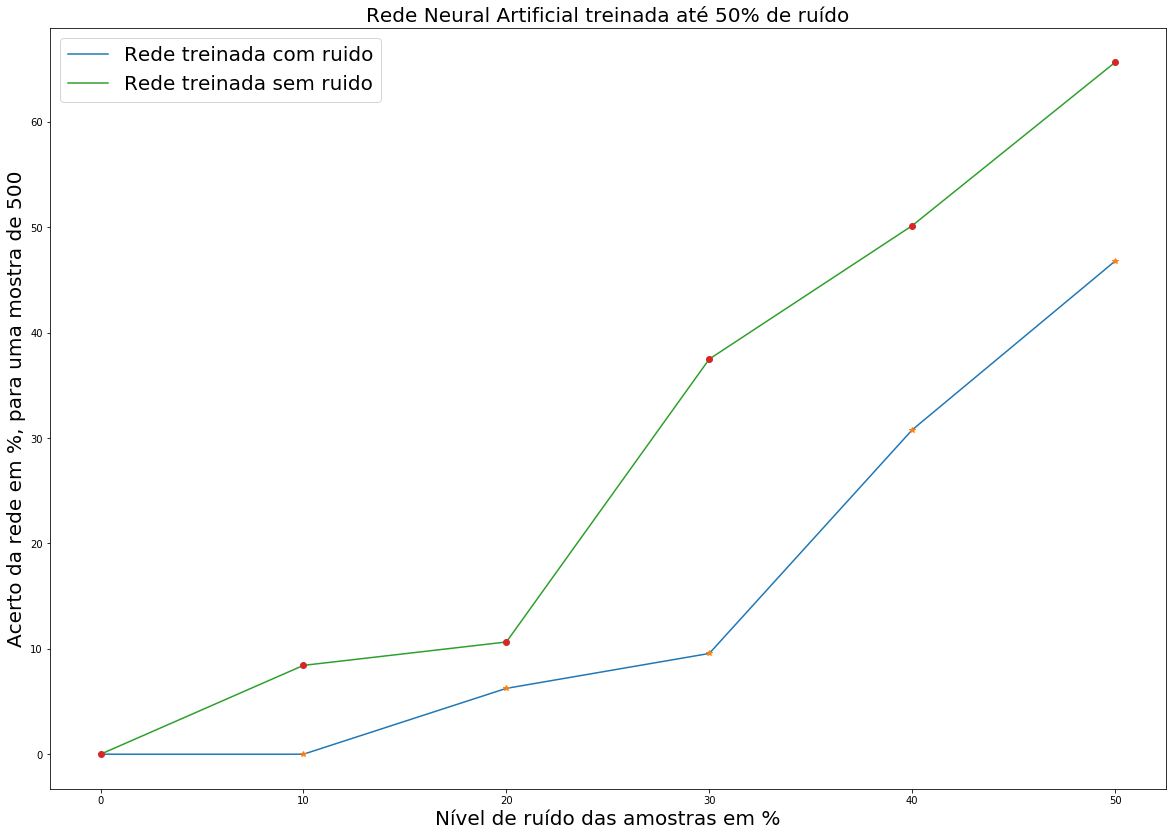

In [24]:
plt.figure(figsize=(20,14))


plt.plot(range(0,NStep*N,NStep),FitV, label='Rede treinada com ruído')
plt.plot(range(0,NStep*N,NStep),FitV,'*')

plt.plot(range(0,NStep*N,NStep),FitO, label='Rede treinada sem ruído')
plt.plot(range(0,NStep*N,NStep),FitO,'o')

#plt.title('ANN trained with up to {0}% of noise'.format(N*Nnv), fontsize=20)
#exemplo acima de como fazer o titulo decente com variaveis, porem eu vou escrever tudo na mão mesmo

plt.title('Rede Neural Artificial treinada até 50% de ruído', fontsize=20)
plt.ylabel('Acerto da rede em %, para uma mostra de 500', fontsize=20)
plt.xlabel('Nível de ruído das amostras em %', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
 
plt.savefig('figANN.pdf')
plt.show()     